# Установка зависимостей

In [1]:
!pip install pytorch_metric_learning
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 19.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image, ImageOps
from tqdm.auto import tqdm
import albumentations as A
from sklearn.model_selection import train_test_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from IPython.display import clear_output
import time
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from pytorch_metric_learning import losses

from transformers import ViTFeatureExtractor, ViTModel


In [ ]:
!unzip -q -o "/content/drive/MyDrive/ИИ_в_поисках_гренландского_кита.zip"

In [ ]:
dir = '/content/Whale ReId 2_mm'

In [ ]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

# Анализ фотографий

In [ ]:
def get_masked_image(path):
  #функция обрезания кита по маске
  mask = (np.array(Image.open(path[:-3]+"png").convert('RGB'))/255).astype(np.uint8)
  img = np.array(Image.open(path[:-3]+"jpg"))
  return Image.fromarray(np.multiply(mask, img))

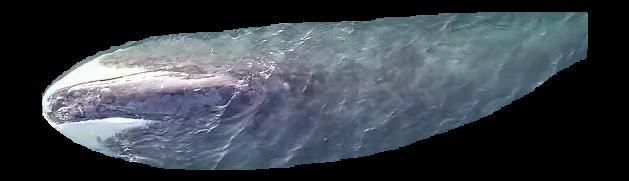

In [ ]:
get_masked_image("/content/Whale ReId 2_mm/1/crop1_DJI_0002/crop1_DJI_0002_1.jpg")

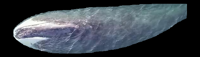

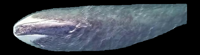

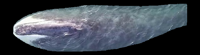

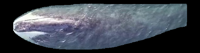

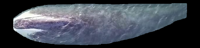

In [ ]:
path = os.path.join(dir, '/content/Whale ReId 2_mm/1/crop1_DJI_0002')
for i in sorted(os.listdir(path))[:10:2]:
  img = get_masked_image(os.path.join(path, i))
  width = 200
  height = img.size[1]/img.size[0] * width
  display(img.resize((int(width), int(height))))

In [ ]:
filename = {'val':[], 'train':[]}
whale_ids = {'val':[], 'train':[]}
counter = 0
for whale_id in os.listdir(dir):
    groups = os.listdir(os.path.join(dir, whale_id))
    for group_i in range(len(groups)):
        group = groups[group_i]
        to_name = "train"
        if group_i % 4 == 2:
            to_name = "val"
        for i in sorted(os.listdir(os.path.join(dir, whale_id, group))):
            if i.endswith('.jpg'):
                path_to_image = os.path.join(dir, whale_id, group, i)
                label = whale_id
                filename[to_name].append(path_to_image)
                whale_ids[to_name].append(whale_id)

Разделение на train/val

In [ ]:
train_data = pd.DataFrame({"filename": filename['train'], "id": whale_ids['train']})
val_data = pd.DataFrame({"filename": filename['val'], "id": whale_ids['val']})

Количество фотографий для каждой особи

<BarContainer object of 20 artists>

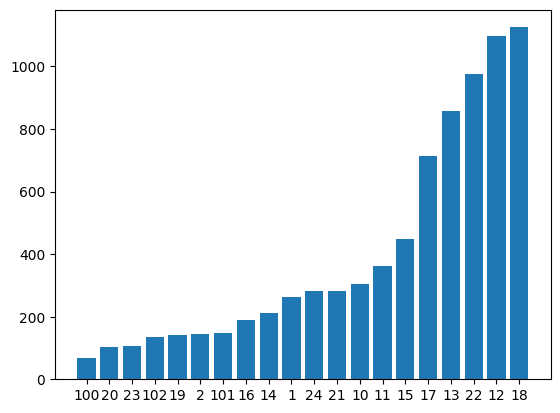

In [ ]:
label2count = dict(train_data['id'].value_counts().sort_values())
plt.bar(label2count.keys(), label2count.values())

На графике слишком сильный разброс значений

Отказ от некоторых изображений в выборке, так как изображения очень похожи. Нужно избежать доминирование каких-то классов в датасете



In [ ]:
filename = {'val':[], 'train':[]}
whale_ids = {'val':[], 'train':[]}
counter = 0
step = 1
count = 1
for whale_id in os.listdir(dir):
    groups = os.listdir(os.path.join(dir,whale_id))
    if label2count[whale_id] <= 30:
        count = 4
    elif label2count[whale_id] <= 40:
        count = 3
    elif label2count[whale_id] <= 60:
        count = 2
    else:
        count = 1
    if label2count[whale_id] >= 500:
        step = label2count[whale_id]//100
    elif label2count[whale_id] >= 300:
        step = 3
    elif label2count[whale_id] >= 200:
        step = 2
    else:
       step = 1
    for group_i in range(len(groups)):
        group = groups[group_i]
        to_name = "train"
        if group_i % 4 == 2:
            to_name = "val"
        for i in sorted([j for j in os.listdir(os.path.join(dir, whale_id, group)) if j.endswith('.jpg')])[::step]:
            path_to_image = os.path.join(dir, whale_id, group, i)
            label = whale_id
            for coco in range(count):
                filename[to_name].append(path_to_image)
                whale_ids[to_name].append(whale_id)

In [ ]:
train_data = pd.DataFrame({"filename": filename['train'], "id": whale_ids['train']})
val_data = pd.DataFrame({"filename": filename['val'], "id": whale_ids['val']})
train_data.to_csv("train_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)

In [ ]:
train_data["id"].value_counts()

16     188
15     151
101    148
2      146
24     141
21     141
19     140
102    134
1      133
11     122
12     111
13     109
22     109
18     108
23     106
14     106
10     103
17     103
20     102
100     67
Name: id, dtype: int64

<BarContainer object of 20 artists>

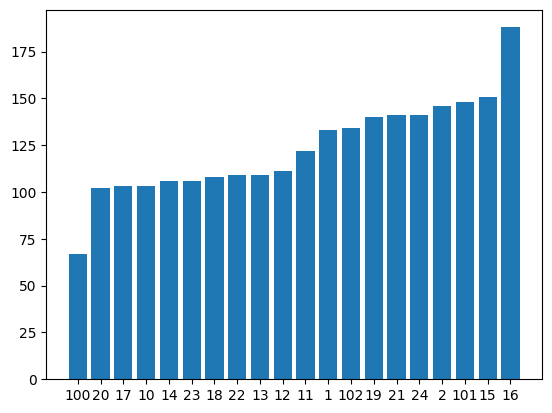

In [ ]:
label2count_new = dict(train_data['id'].value_counts().sort_values())
plt.bar(label2count_new.keys(), label2count_new.values())

График выглядит значительно лучше. Разброс значений стал меньше.

Просмотр количества данных

In [ ]:
train = pd.read_csv("/content/train_data.csv")
val = pd.read_csv("/content/val_data.csv")
print("Unique train ids: ", len(sorted(train["id"].unique())))
print("Unique val ids: ",len(sorted(val["id"].unique())))

Unique train ids:  20
Unique val ids:  13


In [ ]:
train_labels = sorted(train["id"].unique())
label2idx = {i: train_labels[i] for i in range(len(train_labels))}
idx2label = {i[1]: i[0] for i in label2idx.items()}
model = 'google/vit-base-patch16-384'
root_dir = dir
batch_size = 16
num_labels = len(label2idx)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

# Создание датасета

## Класс для создания датасета

In [ ]:
class LandmarkDataset(Dataset):

    def __init__(self, meta, root_dir, transform=None):
        self.meta = meta
        self.root_dir = root_dir
        self.transform = transform
        self.tr = transforms.RandomRotation(90)


    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()


        img_name = os.path.join(
            self.root_dir,
            self.meta['filename'].iloc[idx]
        )
        #print(img_name)
        image = self.get_masked_image(img_name)
        #display(image)
        if self.transform:
            image = self.tr(image)
            image = self.transform(image=np.asarray(image))['image']
            image = Image.fromarray(image)
        #display(image)
        image = feature_extractor(images=image, return_tensors="pt")
        cls = idx2label.get(self.meta['id'].iloc[idx], -1)
        return image, cls

    def get_masked_image(self, path):
        #метод обрезания кита по маске
        mask = (np.array(Image.open(path[:-3]+"png").convert('RGB'))/255).astype(np.uint8)
        img = np.array(Image.open(path[:-3]+"jpg"))
        return Image.fromarray(np.multiply(mask, img))

## Конвейер преобразований фотографий

In [ ]:
train_transform = A.Compose([
        A.RandomRotate90(p=1),
        A.GaussNoise(p=0.2),
        A.RandomContrast(p=0.3),
        A.OneOf([
            A.MotionBlur(p=.2),
            A.MedianBlur(blur_limit=3, p=0.1),
            A.Blur(blur_limit=3, p=0.1),
        ], p=0.2),
        A.OneOf([
            A.CLAHE(clip_limit=2),
            A.Sharpen(),
            A.Emboss(),
            A.RandomBrightnessContrast(),
        ], p=0.3),
        A.HueSaturationValue(p=0.3),
    ])

transform = None

/usr/local/lib/python3.10/dist-packages/albumentations/augmentations/transforms.py:1639: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


# Подготовка к обучению

## Загрузка предобученной модели

In [ ]:
feature_extractor = ViTFeatureExtractor.from_pretrained(model)
feature_extractor.save_pretrained('feature_extractor')
model = ViTModel.from_pretrained(model)
model.to(device)
'''model = ViTModel.from_pretrained('/content/drive/MyDrive/model')
model.to(device)'''

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


"model = ViTModel.from_pretrained('/content/drive/MyDrive/model')\nmodel.to(device)"

In [ ]:
train_dataset = LandmarkDataset(meta=train, root_dir="", transform=train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8)
val_dataset = LandmarkDataset(meta=val, root_dir="", transform=None)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=None, num_workers=8)

In [ ]:
EPOCHS = 5
lr = 0.00001
#Выбор оптимизатора
optimizer = optim.AdamW(model.parameters(), lr)
criterion = losses.ArcFaceLoss(num_labels, 768).to(device)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-9)

# Обучение

Составление среднего вектора признаков для каждой особи

In [ ]:
start_time = time.time()
embeddings_dict = {}
for epoch in range(5):
    embeddings_dict = {}
    model.train()
    correct, total = 0, 0
    train_loss = []
    for batch, targets in tqdm(train_dataloader, desc=f"Epoch: {epoch}"):
        optimizer.zero_grad()
        for i in batch:
            batch[i] = batch[i][:, 0].to(device)
        targets = targets.to(device)
        predictions = model(**batch).pooler_output
        loss = criterion(predictions, targets)
        loss.backward()
        optimizer.step()
        train_loss.append(loss.item())
        correct += torch.sum(torch.argmax(predictions, dim=1)==targets).detach().cpu().item()
        total += len(targets)
        #########################
        for i in range(len(targets)):
            embeddings_dict[int(targets[i])] =  embeddings_dict.get(int(targets[i]), [])+[predictions[i]]
        #####################3###
    train_acc = correct/total
    print('Training loss:', np.mean(train_loss))
    model.eval()
    val_loss = []
    for batch, targets in tqdm(val_dataloader, desc=f"Epoch: {epoch}"):
        with torch.no_grad():
            correct, total = 0, 0
            for i in batch:
                batch[i] = batch[i][:, 0].to(device)
            targets = targets.to(device)
            predictions = model(**batch).pooler_output
            loss = criterion(predictions, targets)
            val_loss.append(loss.item())
            correct += torch.sum(torch.argmax(predictions, dim=1)==targets).detach().cpu().item()
            total += len(targets)
    if total==0:
        total = 1
    val_acc = correct/total
    print('Val loss:', np.mean(val_loss))
    clear_output()
    print(f"Finished: {epoch +1}")
    print("Train loss:", np.mean(train_loss))
    print("Val loss:", np.mean(val_loss))
    time_still_running = time.strftime(f"%H:%M:%S" ,time.gmtime(time.time()-start_time))
    print(f"Training time: {time_still_running}")
    model.save_pretrained('/content/drive/MyDrive/model')
    embeddings = {}
    for i in sorted(embeddings_dict.keys()):
        embeddings[i] = torch.stack(embeddings_dict[i]).mean(axis=0).cpu().detach().numpy()
    df = pd.DataFrame(embeddings)
    # df.columns = [label2idx[i] for i in df.columns]
    df.to_csv("/content/drive/MyDrive/base.csv" ,index=False)

In [ ]:
!zip -r best_model.zip /content/drive/MyDrive/model

In [ ]:
embeddings = {}
for i in sorted(embeddings_dict.keys()):
  embeddings[i] = torch.stack(embeddings_dict[i]).mean(axis=0).cpu().detach().numpy()
df = pd.DataFrame(embeddings)
df.columns = [label2idx[i] for i in df.columns]
df.to_csv("base.csv" ,index=False)

In [ ]:
df=pd.read_csv("/content/drive/MyDrive/base.csv")
base = df.values.T

In [ ]:
from scipy.spatial.distance import cosine
def get_metric_prediction(
    model,
    device,
    base,
    img):

    # img = feature_extractor(img, return_tensors="pt")
    img.to(device)

    # инференс модели и получение предикта
    model.eval()
    with torch.no_grad():
        prediction = model(**img).pooler_output
        prediction = prediction[0].cpu().detach().numpy()

    dist = []
    for emb in base:
        dist.append(cosine(emb, prediction)) # считаем косинусное расстояние

    class_idx = np.argmin(np.array(dist)) # берем индекс наименьшего расстояния - близжайший класс

    return class_idx, np.array(dist).min() #correct_class

In [ ]:
total = 0
correct = 0
distances = []
from tqdm import tqdm
dataset_for_test = train_dataset
for i in tqdm(range(len(dataset_for_test)), total=len(dataset_for_test)):
    metric_result, distance = get_metric_prediction(model, device, base,dataset_for_test[i][0])
    distances.append(distance)
    total += 1
    if int(dataset_for_test[i][1])==metric_result:
      correct += 1

print()
print(distances)

In [ ]:
print("{:.4f}".format(correct/total))

### Получение предсказания для тестовых данных

In [ ]:
import os
import random
import pandas as pd
import numpy as np
from PIL import Image
from tqdm.auto import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader
from scipy.spatial.distance import cosine
from transformers import ViTFeatureExtractor, ViTModel

In [ ]:
!gdown 1-7ReYdLBa4exW0L_nJai_PXsCk1AUAgY

In [ ]:
!gdown 102Xlb8Eok2G38zD2HkqzvkFYtw-mA5l1

In [ ]:
!unzip -q /content/Whale_ReId_test_mm.zip

In [ ]:
!gdown 1VokuHrFZYp6lLuTCZqEHopTIF3AWmLPQ

In [ ]:
!unzip -q "/content/trained_model (3).zip"

In [ ]:
THRESHOLD = 0.74 # подобраный трешхолд, для улучшения скора
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)
extractor = 'google/vit-base-patch16-384'
model = '/content/model'  # путь до обученной модели
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
df = pd.read_csv("/content/base.csv")  # файл .csv со средними векторами признаков для каждого класса
base = df.values.T
feature_extractor = ViTFeatureExtractor.from_pretrained(extractor)
model = ViTModel.from_pretrained(model)
model.to(device)

def get_metric_prediction(model, device, base, img):
    img.to(device)
    # инференс модели и получение предикта
    model.eval()
    with torch.no_grad():
        prediction = model(**img).pooler_output
        prediction = prediction[0].cpu().detach().numpy()
    dist = []
    for emb in base:
        dist.append(cosine(emb, prediction))  # считаем косинусное расстояние
    class_idx = np.argmin(np.array(dist))  # берется индекс наименьшего расстояния - близжайший класс
    return class_idx, np.array(dist).min()


def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


class TestDataset(Dataset):

    def __init__(self, meta, root_dir, f_extractor):
        self.meta = meta
        self.root_dir = root_dir
        self.feature_extractor = f_extractor

    def __len__(self):
        return len(self.meta)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(
            self.root_dir,
            self.meta['filename'].iloc[idx]
        )
        # print(img_name)
        image = self.get_masked_image(img_name)
        image = self.feature_extractor(images=image, return_tensors="pt")
        return image

    def get_masked_image(self, path):
        mask = (np.array(Image.open(path[:-3] + "png").convert('RGB')) / 255).astype(np.uint8)
        img = np.array(Image.open(path[:-3] + "jpg"))
        return Image.fromarray(np.multiply(mask, img))


def folder_with_images(path_to_folder_with_images):
    filename = []
    whale_folders = []
    for i in os.listdir(path_to_folder_with_images):
        if i.endswith('.jpg'):
            path_to_image = os.path.join(path_to_folder_with_images, i)
            filename.append(path_to_image)
            whale_folders.append(i)
    data = pd.DataFrame({"filename": filename, "whale_folder": whale_folders})
    dataset = TestDataset(meta=data, root_dir="", f_extractor=feature_extractor)
    infer_dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(infer_dataloader)):
            for i in batch:
                batch[i] = batch[i][:, 0].to(device)
            prediction = model(**batch).pooler_output
            prediction = prediction[0].cpu().detach().numpy()

            dist = []
            for emb in base:
                dist.append(cosine(emb, prediction))
            class_idx = np.argmin(np.array(dist))
            # print(int(class_idx), dist[class_idx])
            if dist[class_idx] < THRESHOLD:
                data.loc[idx, 'class'] = class_idx+1
            else:
                data.loc[idx, 'class'] = int(0)
    data = data.iloc[:, 1:]
    data['class'] = data["class"].astype("int64")
    return data


def folderinfolder(path_to_folder_with_folders):
    foldernames = []
    r1 = []
    r2 = []
    r3 = []
    r4 = []
    r5 = []
    for i in os.listdir(path_to_folder_with_folders):
        rez = for_one_folder(os.path.join(path_to_folder_with_folders, i))
        r1.append(rez[0])
        r2.append(rez[1])
        r3.append(rez[2])
        r4.append(rez[3])
        r5.append(rez[4])
        foldernames.append(i)

    return pd.DataFrame({'name':foldernames, 'top1':r1, 'top2':r2, "top3":r3, 'top4':r4, "top5":r5})



def for_one_folder(folder_path):
    filename = []
    whale_folders = []
    for fldr in os.listdir(folder_path):
        for i in os.listdir(os.path.join(folder_path, fldr)):
            if i.endswith('.jpg'):
                path_to_image = os.path.join(folder_path, fldr, i)
                filename.append(path_to_image)
                whale_folders.append(i)
    data = pd.DataFrame({"filename": filename, "whale_folder": whale_folders})
    total = 0
    predictions = np.array([0 for i in range(768)]).astype('float64')
    dataset = TestDataset(meta=data, root_dir="", f_extractor=feature_extractor)
    infer_dataloader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=4)
    with torch.no_grad():
        for idx, batch in enumerate(tqdm(infer_dataloader)):
            for i in batch:
                batch[i] = batch[i][:, 0].to(device)
            prediction = model(**batch).pooler_output
            prediction = prediction[0].cpu().detach().numpy()
            predictions += prediction
            total += 1
        prediction = predictions / total
        dist = []
        for emb in base:
            dist.append(cosine(emb, prediction))
        # class_idx = np.argmin(np.array(dist))
        dist = sorted([(dist[i], i) for i in range(len(dist))])[:5]

        # print(dist)
        ans = []
        for distancia, class_idx in dist:
            if distancia < THRESHOLD:
                ans.append(int(class_idx)+1)
            else:
                ans.append(int(0))
        return ans


def get_result_of_image_by_path(path):
    dataset = TestDataset(pd.DataFrame({"filename": [path], "whale_folder":['no']}), '', feature_extractor)
    class_idx, distance_of_im = get_metric_prediction(model, device, base, dataset[0])
    if distance_of_im < THRESHOLD:
        class_idx = class_idx + 1
    else:
        class_idx = int(0)
    return class_idx

In [ ]:
data = folderinfolder("/content/Whale_ReId_test_mm")

In [ ]:
data.head()

In [ ]:
data.to_csv('pred.csv', index=False, sep=";")